In [4]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 13:00:38.485336
numcores: 8


In [5]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [6]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [8]:
with model:
    #{'advi', 'svgd', 'nfvi', 'fullrank_advi', 'asvgd'}
    approx = pm.fit(method='svgd', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]);

trace = approx.sample(5000);
print(pm.summary(trace));

KeyError: "method should be one of {'advi', 'svgd', 'nfvi', 'fullrank_advi', 'asvgd'} or Inference instance"

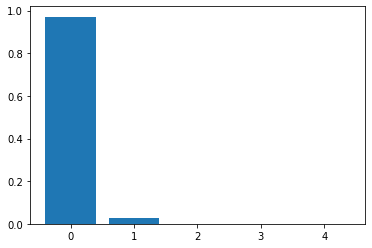

In [18]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

In [26]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

/Users/aidasaglinskas/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/Users/aidasaglinskas/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1567x77617 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1987.2x1656 with 20 Axes>

In [20]:
t_finish=now()

In [21]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:00:38.926866


In [22]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [ ]:
#with model:
#    trace = pm.find_MAP()